# Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

from sklearn.metrics import roc_auc_score, roc_curve

sns.set_style('whitegrid')
%matplotlib inline

print 'pandas\t\t%s' % pd.__version__
print 'numpy\t\t%s' % np.__version__
print 'matplotlib\t%s' % mpl.__version__
print 'seaborn\t\t%s' % sns.__version__
print 

!conda --version
!python --version

pandas		0.22.0
numpy		1.10.2
matplotlib	2.1.1
seaborn		0.8.0

conda 4.3.29
Python 2.7.13 :: Continuum Analytics, Inc.


# Import user-defined functions

In [2]:
def extractMaximumPerformance(auc_df):
    ''' 
    in a pandas.DataFrame of single column, find maximum value and its corresponding index
    '''
    
    auc_max = auc_df.max().values[0]
    auc_index = auc_df.iloc[np.where(auc_df == auc_max)[0]].index[0]
    
    return auc_max, auc_index

# Import data

**Import clinical outcomes (labels)**

In [3]:
filename = '../generate_data/input_data/suscpetibility/outcomes.ygbr.day.2.txt'
y_all = pd.read_csv(filename,sep='\t',header=0,index_col=0)

**Import hold-out model decision scores**

In [4]:
hov_df_dict = {};
hov_fname_dict = {'clinical':'S001_cv1_59024160',
                  'microbiota':'S100_cv1_59024160',
                  'combined':'S101_cv1_59024160',}

for key,value in hov_fname_dict.iteritems():
    
    filename = '../generate_data/output_data/%s/decision_scores.txt' % value
    hov_df_dict[key] = pd.read_csv(filename,sep='\t',header=0,index_col=0)
    hov_df_dict[key] = hov_df_dict[key][hov_df_dict[key].any(1)]

**Compute hold-out model Area under the ROC curve (AuROC)**

In [5]:
hov_auc_dict = {};

for model in hov_fname_dict.keys():
   
    # table of prediction scores with prediction samples x number of features in model 
    df_scores = hov_df_dict[model];
    
    # true labels of prediction samples
    y_true = np.ravel(y_all.loc[df_scores.index,:].values)
    
    roc_list = [];
    for col in range(df_scores.shape[1]):
        
        # predictions for _col_ features in model
        y_pred = df_scores.iloc[:,col]
        
        # compute auc
        auc = roc_auc_score(y_true,y_pred)
        
        # extract number of features
        numFeatures = int(df_scores.keys()[col].split('_f')[0])

        # save info in tuple and stack
        roc_list.append((numFeatures,auc))
    
    df = pd.DataFrame(roc_list,columns=['NumFeatures','AuROC'])
    df = df.set_index(['NumFeatures'])
    hov_auc_dict[model] = df

**Import cross-validated model auc scores**

In [6]:
cv_auc_dict = {};
cv_fname_dict = {'clinical':'S001_cv2_30_10_59024160',
                 'microbiota':'S100_cv2_30_10_936094365',
                 'combined':'S101_cv2_30_10_60953643'}

for key,value in cv_fname_dict.iteritems():
    
    filename = '../generate_data/output_data/%s/auc_scores.txt' % value
    cv_auc_dict[key] = pd.read_csv(filename,sep='\t',header=[0,1],index_col=0)

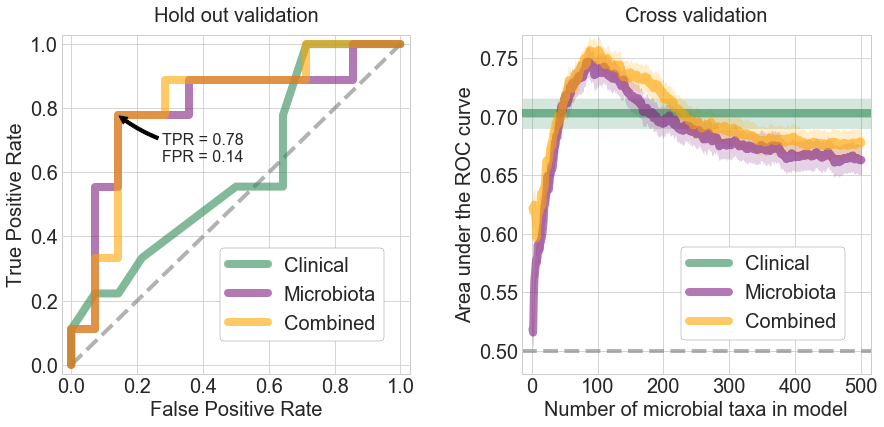

In [10]:
fig   = plt.figure(figsize=(13,7.75)); 
fig   = plt.figure(figsize=(14.5,6.25));
gs    = gridspec.GridSpec(1,2,width_ratios=[1.,1.],hspace=0.4,wspace=0.32);

ax_ = {};

ax_[0] =  plt.subplot(gs[0,0]);
ax_[1] =  plt.subplot(gs[0,1]);


fig_params = pd.DataFrame(
    index=['clinical','microbiota','combined'],
    columns = ['Label','Color_R','Color_G','Color_B','alpha','Zorder']);

fig_params.loc[:,'Label'] = ['Clinical','Microbiota','Combined'] ;
fig_params.loc[:,'Zorder'] = [6,6,9];
fig_params.loc[:,'Color_R'] = [ 46./255, 128./255, 255./255];
fig_params.loc[:,'Color_G'] = [139./255,  32./255, 165./255];
fig_params.loc[:,'Color_B'] = [ 87./255, 128./255,   0./255];
fig_params.loc[:,'alpha'] = [0.6,0.6,0.6];

fp = fig_params.copy();

for model in fig_params.index:
        
    auc_max,auc_index = extractMaximumPerformance(auc_df=hov_auc_dict[model])
    decision_scores = hov_df_dict[model].loc[:,'%s_f' % auc_index];
    true_labels = y_all.loc[decision_scores.index];
    fpr,tpr,thresholds = roc_curve(true_labels,decision_scores);
    
    tpr = [0]+list(tpr);
    fpr = [0]+list(fpr);
    
    color = (fp.loc[model,'Color_R'],
             fp.loc[model,'Color_G'],
             fp.loc[model,'Color_B'],
             fp.loc[model,'alpha']);
    
    ax_[0].plot(fpr,tpr,
                lw=8,ls='-',
                color=color,
                zorder=fp.loc[model,'Zorder'],
                label=fp.loc[model,'Label']);
 
    
ax_[0].plot([0,1],[0,1],linestyle='--',color='gray',lw=4,zorder=1,alpha=0.6);

ax_[0].set_xlabel('False Positive Rate',fontsize=20);
ax_[0].set_ylabel('True Positive Rate',fontsize=20);

[ii.set_fontsize(20) for ii in ax_[0].get_xticklabels()];
[ii.set_fontsize(20) for ii in ax_[0].get_yticklabels()];

ax_[0].set_xlim([-.03,1.03]);
ax_[0].set_ylim([-0.03,1.03]);

ax_[0].set_title('Hold out validation',fontsize=20,y=1.02);
ax_[0].grid(True,which='both',zorder=1);

for model in fig_params.index:
    
    auc_df = cv_auc_dict[model];
    auc_mean = auc_df.mean(1);
    auc_sem = auc_df.sem(1);
    auc_high = auc_mean + auc_df.sem(1);
    auc_low = auc_mean - auc_df.sem(1);
    
    x_range = range(1,auc_mean.shape[0]+1)[::-1]

    color = (fp.loc[model,'Color_R'],
             fp.loc[model,'Color_G'],
             fp.loc[model,'Color_B'],
             fp.loc[model,'alpha']);
    
    if len(auc_mean)==1:
        auc_mean = pd.DataFrame([auc_mean.values[0]]*531);
        auc_high = [auc_high.values[0]]*531;
        auc_low = [auc_low.values[0]]*531;
        x_range = range(-15,516);
    
    ax_[1].plot(x_range,auc_mean,color=color,
                lw=8,ls='-',
                zorder=fp.loc[model,'Zorder'],
                label=fp.loc[model,'Label']); 
    
    ax_[1].fill_between(x=x_range,
                        y1=auc_low,y2=auc_high,
                        color=color,lw=0.25,alpha=0.2);
    

    
ax_[1].axhline(y=0.5,xmin=0,xmax=1,linestyle='--',color='gray',lw=4,zorder=1,alpha=0.6);
        
ax_[1].set_xlabel('Number of microbial taxa in model',fontsize=20);
ax_[1].set_ylabel('Area under the ROC curve',fontsize=20);
[ii.set_fontsize(20) for ii in ax_[1].get_xticklabels()];
[ii.set_fontsize(20) for ii in ax_[1].get_yticklabels()];

ax_[1].set_ylim([0.485,1.015]);
ax_[1].set_ylim([0.48,.77]);
ax_[1].set_xlim([-15,515]);
    
ax_[1].set_title('Cross validation',fontsize=20,y=1.02);
ax_[0].grid(True,which='both',zorder=1);

### legend #1

lgd = ax_[0].legend(bbox_to_anchor=(0.980,0.395), bbox_transform=ax_[0].transData,
                shadow=False, frameon=True, ncol=1,fontsize=20);
frame = lgd.get_frame();
frame.set_facecolor('white');
frame.set_alpha(1);
frame.set_edgecolor((0,0,0));
frame.set_linewidth(0.2);


### legend #2
lgd = ax_[1].legend(bbox_to_anchor=(211,0.5975), bbox_transform=ax_[1].transData,
                    shadow=False, frameon=True, ncol=1,fontsize=20); # same as axes 1
frame = lgd.get_frame();
frame.set_facecolor('white');
frame.set_alpha(1);
frame.set_edgecolor((0,0,0));
frame.set_linewidth(0.2);



###

ax_[0].annotate('TPR = 0.78\nFPR = 0.14',
                xy=(0.14,0.78),
                xytext=(0.275,0.725),
                textcoords='data',xycoords='data',
                size=16,va="top",ha="left",
                arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=-0.15",color='black'),
                zorder=12);


plt.savefig('./figs/midani_figure_2_roc_curves.pdf',filetype='pdf');